In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [2]:
opt = {
    "dimension": 3,
    "num_atoms":1000,
    "type_atoms": 3,
    "hidden_size": 100,
    "simulate": 1000
}

In [3]:
# Atom Coordinates
class AtomCoordinates(nn.Module):
    def __init__(self, num_atoms, type_atoms, dimension, scale=1):
        super(AtomCoordinates, self).__init__()
        self.coordinates = nn.Parameter(torch.randn(num_atoms, dimension)*scale)
        self.types = nn.Parameter(torch.randint(-(type_atoms//2), (type_atoms+1)//2, (num_atoms,)), requires_grad=False)

    def forward(self):
        return self.coordinates

In [4]:
# Utility
def distances_matrix(coordinates, atom_types):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates, coordinates)
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]

    type_pair_matrix = torch.cartesian_prod(atom_types, atom_types).reshape(matrix_size, matrix_size, 2)
    type_pairs = type_pair_matrix[indices[0], indices[1]]
    
    return distances, type_pairs

In [5]:
# Data
def lennard_jones_potential(r, t, a=2, b=2, k=1, eps=1e-1):
    rep = (k * t[:,:1] * t[:,1:]).clone().detach()
    return (1 / ((r+eps)/(a+rep)) ** 12) - (1 / ((r+eps)/(b+rep))**6)

def simulate(force_field, atom_coordinates, atom_types, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        distances, type_pairs = distances_matrix(atom_coordinates, atom_types)
        potential_energy = torch.sum(force_field(distances.view(-1, 1), type_pairs))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 100 == 0:  # Adjust the frequency of printing as needed
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

In [6]:
stable_coordinates = AtomCoordinates(opt["num_atoms"], opt["type_atoms"], opt["dimension"]).to(device)
simulate(lennard_jones_potential, stable_coordinates.coordinates, stable_coordinates.types, num_iterations=5000)

Iteration 0, Potential Energy: 9255957318074368.0
Iteration 100, Potential Energy: 1352727040.0
Iteration 200, Potential Energy: 12416877.0
Iteration 300, Potential Energy: 481613.3125
Iteration 400, Potential Energy: 30277.560546875
Iteration 500, Potential Energy: 79.04975128173828
Iteration 600, Potential Energy: -1878.7685546875
Iteration 700, Potential Energy: -1944.5023193359375
Iteration 800, Potential Energy: -1973.5523681640625
Iteration 900, Potential Energy: -1984.8055419921875
Iteration 1000, Potential Energy: -1991.69482421875
Iteration 1100, Potential Energy: -1999.3594970703125
Iteration 1200, Potential Energy: -2004.1182861328125
Iteration 1300, Potential Energy: -2005.501708984375
Iteration 1400, Potential Energy: -2005.8304443359375
Iteration 1500, Potential Energy: -2005.9647216796875
Iteration 1600, Potential Energy: -2006.2877197265625
Iteration 1700, Potential Energy: -2006.80029296875
Iteration 1800, Potential Energy: -2006.7958984375
Iteration 1900, Potential En

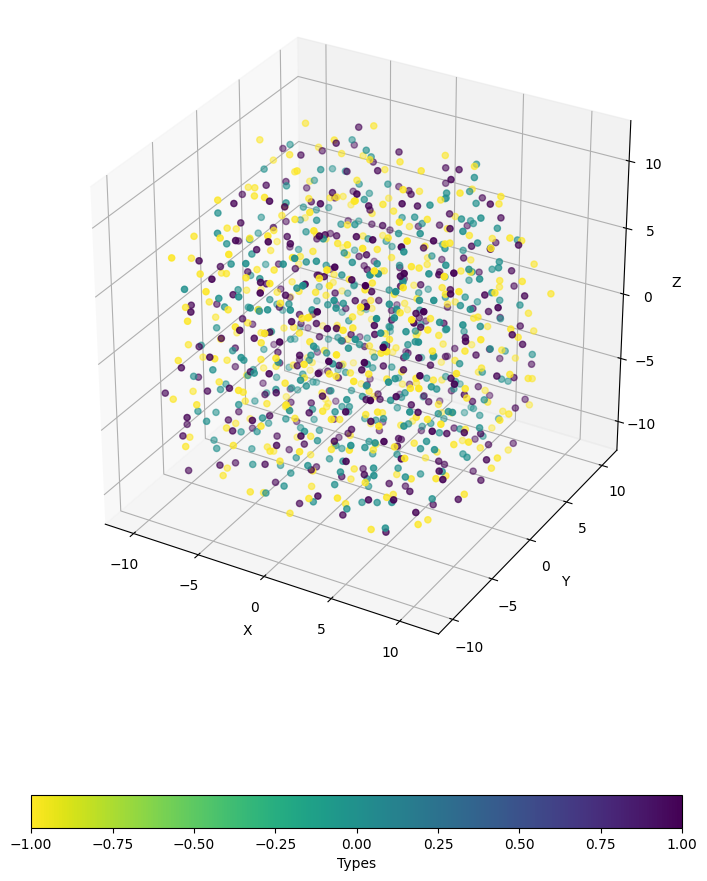

In [7]:
coordinates = stable_coordinates.coordinates.cpu().detach().numpy()
types = stable_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.7, orientation='horizontal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([1, 1, 1])
plt.show()

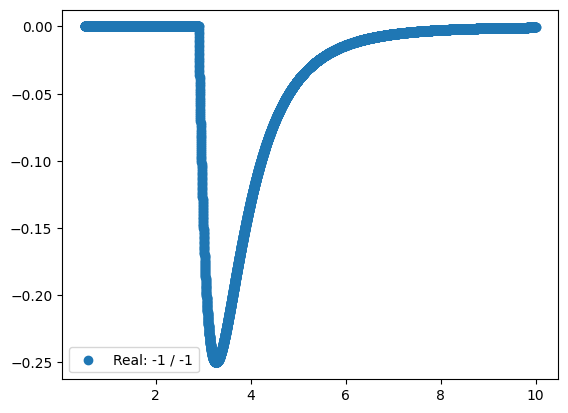

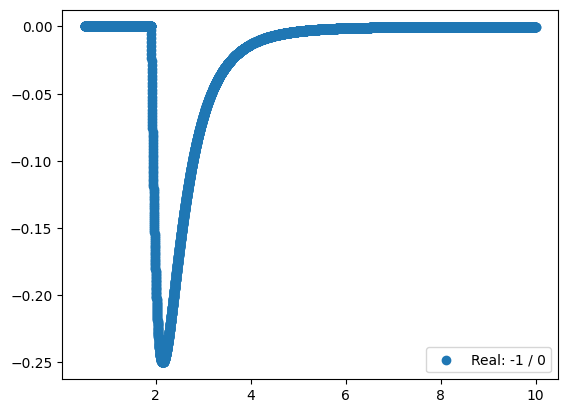

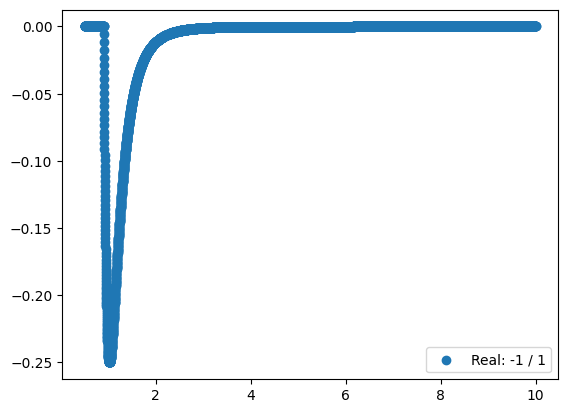

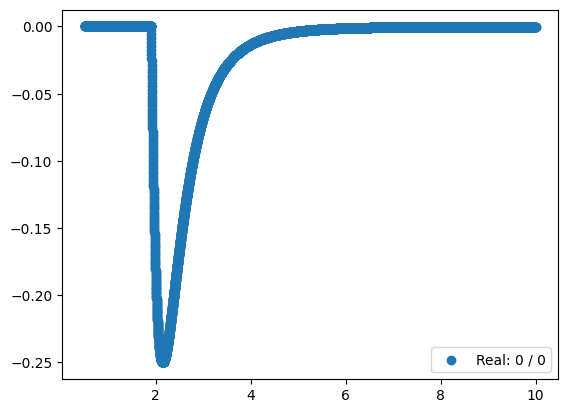

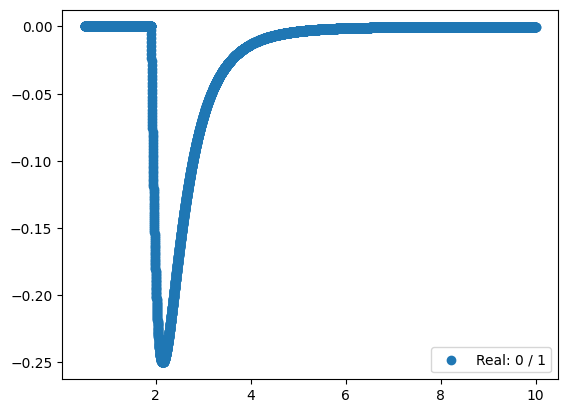

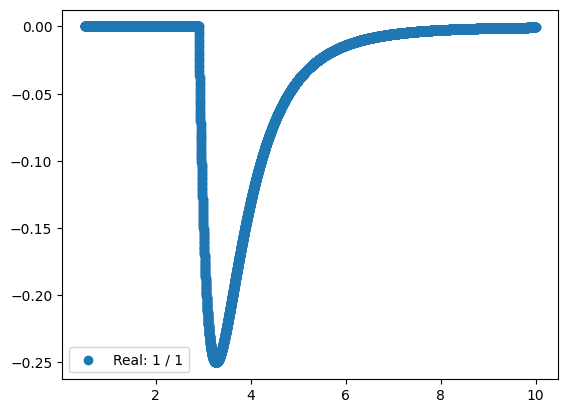

In [8]:
for i in range(-(opt["type_atoms"]//2), (opt["type_atoms"]+1)//2):
    for j in range(i, (opt["type_atoms"]+1)//2):
        x_data = torch.arange(0.5, 10.0, 0.001).unsqueeze(1).to(device)
        x_pair = torch.zeros(x_data.shape[0], 2).to(device)
        x_pair[:,0] = i
        x_pair[:,1] = j
        y_real = lennard_jones_potential(x_data, x_pair)
        y_real = torch.clamp(y_real, -0.3, 0)
        plt.scatter(x_data.cpu().numpy(), y_real.cpu().numpy(), label=f"Real: {i} / {j}")
        plt.legend()
        plt.show()

# Save

In [ ]:
coordinates = stable_coordinates.coordinates.cpu().detach().numpy()
types = stable_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.7, orientation='horizontal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()